# **차량 공유업체의 차량 파손 여부 분류하기**

## 0.미션

* 1) 미션1 : Data Preprocessing
    - **과제 수행 목표**
        - 모델링 수행을 위해 적절한 폴더 및 파일로 **일관성 있게 정리**해야 합니다.
        - 제공된 데이터 : Car_Images.zip
            * Car_Images : 차량의 정상/파손 이미지 무작위 수집

* 2) 미션2 : CNN 모델링
    - **과제 수행 목표**
        - Keras를 이용하여 모델을 3개 이상 생성하세요.
            - 모델 구조와 파라미터는 자유롭게 구성하세요.
            - 단, 세부 목차에서 명시한 부분은 지켜주세요.

* 3) 미션3 : Transfer Learning
    - **과제 수행 목표**
        - 성능 개선을 위해 다음의 두가지를 시도하세요.
            * Image Preprocessing Layer, Image Augmentation Layer를 통해 이미지를 변형시켜 봅시다.
            * Transfer Learning(Inception V3)
* 성능 가이드
    * Accuracy : 0.34~0.74

## 1.환경설정

* **세부 요구사항**
    - 경로 설정 : Google Colaboratory의 가상 컴퓨터 안에 데이터셋을 다운로드 받고 압축을 해제하세요.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.

In [ ]:
!pip install keras --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 37.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.0 which is incompatible.


In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

### (1) 라이브러리 불러오기

In [ ]:
import gdown, zipfile
import os, glob, shutil
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

### (2) 데이터 불러오기

#### 1) 데이터 다운로드

In [ ]:
# def download_file(file_id, save_path) :
#     if os.path.exists(save_path) :
#         print(f'{save_path} 파일이 이미 존재합니다.')
#         return

#     gdown.download(id=file_id, output=save_path, quiet=False)

In [ ]:
# file_id = '1JHo4Rsb8Mx-sJqu7xdQWUgrfAf3H1g7W'

# download_file(file_id, 'car_images.zip')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 2) 데이터 압축 해제

In [ ]:
# import shutil

# shutil.rmtree('/content/Car_Images')

In [ ]:
def dataset_extract(file_name):
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        file_list = zip_ref.namelist()
        if os.path.exists(f'/content/{file_name[-14:-4]}/'):
            print(f'데이터셋 폴더가 이미 존재합니다.')
            return
        else:
            for f in tqdm(file_list, desc='Extracting', unit='files'):
                zip_ref.extract(member=f, path=f'/content/{file_name[-14:-4]}/')

In [ ]:
dataset_extract('/content/drive/MyDrive/AIVLE_SCHOOL_5th/미프4차/Car_Images.zip')

Extracting: 100%|██████████| 607/607 [00:09<00:00, 64.25files/s]


#### 2) 데이터 조회

In [ ]:
# 폴더별 이미지 데이터 갯수 확인
import os

folder_path = "/content/Car_Images/abnormal"
file_list = os.listdir(folder_path)
abnormal_file_count = len(file_list)
print(abnormal_file_count)

file_list = os.listdir('/content/Car_Images/normal')
normal_file_count = len(file_list)
print(normal_file_count)

303
302


In [ ]:
from keras.utils import load_img, img_to_array

(1024, 1024, 3)


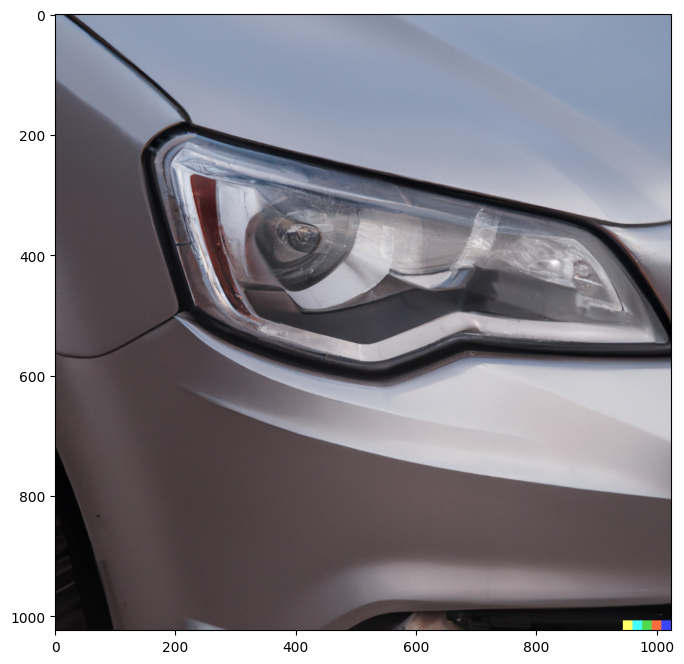

In [ ]:
# 정상 차량 랜덤 이미지 확인 및 형태 확인
image_org = load_img("/content/Car_Images/normal/DALLíñE 2023-03-10 18.50.25 - photo of a part of car.png")
image = img_to_array(image_org)
print(image.shape)  # height, width, channel

plt.figure(figsize=(12,8))
# plt.imshow(image)
plt.imshow(image/255)
plt.show()

(1024, 1024, 3)


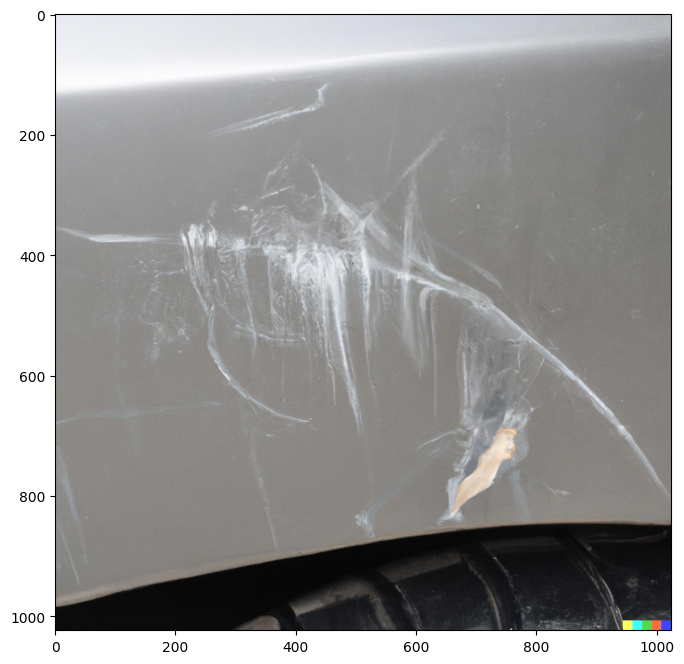

In [ ]:
# 파손 차량 랜덤 이미지 확인 및 형태 확인
image_org = load_img("/content/Car_Images/abnormal/DALLíñE 2023-03-10 18.51.26 - scratched car.png")
image = img_to_array(image_org)
print(image.shape)  # height, width, channel

plt.figure(figsize=(12,8))
# plt.imshow(image)
plt.imshow(image/255)
plt.show()

## 2.데이터 전처리
* 모델링을 위한 데이터 구조 만들기
    * X : 이미지를 array로 변환합니다.
    * Y : 이미지 갯수만큼 normal - 0, abnormal - 1 로 array를 만듭니다.

### (1) Y : 클래스 만들기
- **세부요구사항**
    - 전체 데이터에 대한 Y를 생성합니다.
    - normal, abnormal 데이터의 수를 확인하고 normal을 0, abnormal을 1로 지정합니다.

### (2) X : 데이터 리스트 통합
- **세부요구사항**
    - 전체 이미지 데이터를 하나의 리스트로 통합합니다.

In [ ]:
import glob
from PIL import Image

In [ ]:
import os

def delete_resize_files(folder_path):
    # 폴더 내 파일 목록을 가져옴
    file_list = os.listdir(folder_path)

    for filename in file_list:
        # 파일의 절대 경로 생성
        file_path = os.path.join(folder_path, filename)

        # 파일 이름에 '_resize'가 포함되어 있는지 확인
        if '_resize' in filename:
            try:
                # 파일 삭제
                os.remove(file_path)
                print(f"Deleted: {file_path}")
            except Exception as e:
                print(f"Error deleting {file_path}: {e}")

# 삭제할 폴더 경로 지정
folder_path = '/content/Car_Images/normal/'
folder_path2 = '/content/Car_Images/abnormal/'
# 함수 호출
delete_resize_files(folder_path)

# 함수 호출
delete_resize_files(folder_path2)

In [ ]:
image_path = '/content/Car_Images/abnormal/*.png'
abnormal_file = [file for file in glob.glob(image_path)]

abnormal_resize = []
for f in abnormal_file:
    img = Image.open(f)
    img_resize = img.resize((280, 280))
    abnormal_resize.append(img_resize.size)

    title, ext = os.path.splitext(f)
    img_resize.save(title + '_resize2' + ext)
print(abnormal_resize)

img_path = '/content/Car_Images/abnormal/'
abnormal_img = os.listdir(img_path) #디렉토리 내 모든 파일 불러오기
abnormal_img_list = [img_path + img for img in abnormal_img if img.endswith(".png") and '_resize2' in img] #지정된 확장자만 필터링

[(280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (28

In [ ]:
abnormal_img_list

['/content/Car_Images/abnormal/DALLíñE 2023-03-11 18.45.56 - scratched car_resize2.png',
 '/content/Car_Images/abnormal/DALLíñE 2023-03-11 15.13.52 - dents of a car_resize2.png',
 '/content/Car_Images/abnormal/DALLíñE 2023-03-11 18.43.34 - slightly dented car_resize2.png',
 '/content/Car_Images/abnormal/DALLíñE 2023-03-11 17.30.50 - slightly dented car_resize2.png',
 '/content/Car_Images/abnormal/DALLíñE 2023-03-11 15.12.50 - dents of a car_resize2.png',
 '/content/Car_Images/abnormal/DALLíñE 2023-03-10 23.49.42 - a part of car without blemish_resize2.png',
 '/content/Car_Images/abnormal/DALLíñE 2023-03-10 18.54.17 - slightly damaged car_resize2.png',
 '/content/Car_Images/abnormal/DALLíñE 2023-03-11 00.16.36 - photo of a part of car without blemish_resize2.png',
 '/content/Car_Images/abnormal/DALLíñE 2023-03-11 17.18.46 - scratched car_resize2.png',
 '/content/Car_Images/abnormal/DALLíñE 2023-03-11 18.41.54 - slightly dented car_resize2.png',
 '/content/Car_Images/abnormal/DALLíñE 202

In [ ]:
image_path = '/content/Car_Images/normal/*.png'
normal_file = [file for file in glob.glob(image_path)]

normal_resize = []
for f in normal_file:
    img = Image.open(f)
    img_resize = img.resize((280, 280))
    normal_resize.append(img_resize.size)

    title, ext = os.path.splitext(f)
    img_resize.save(title + '_resize2' + ext)
print(normal_resize)

img_path = '/content/Car_Images/normal/'

normal_img = os.listdir(img_path) #디렉토리 내 모든 파일 불러오기
normal_img_list = [img_path + img for img in normal_img if img.endswith(".png") and '_resize2' in img] #지정된 확장자만 필터링

[(280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (280, 280), (28

In [ ]:
print(len(normal_img_list), len(abnormal_img_list))

302 303


In [ ]:
x = abnormal_img_list + normal_img_list

In [ ]:
len(x)

605

In [ ]:
# y 라벨링
y = []
for file_name in x:
    if 'abnormal' in file_name:
        y.append(1)
    elif 'normal' in file_name:
        y.append(0)
print(y)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### (3) 데이터셋 분리
- **세부요구사항**
    - 데이터 스플릿의 비율 (1) : train set, test set = 90%, 10%으로 설정하세요.
    - 데이터 스플릿의 비율 (2) : train set, valid set = 90%, 10%으로 설정하세요.

In [ ]:
from sklearn.model_selection import train_test_split
x = np.array(x)
y = np.array(y)
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=.1, random_state=2024)

In [ ]:
train_x.shape, test_x.shape, train_y.shape, test_x.shape

((544,), (61,), (544,), (61,))

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=.1, random_state=2024)

In [ ]:
train_x.shape, val_x.shape, train_y.shape, val_x.shape

((489,), (55,), (489,), (55,))

### (4) X : image to array
- **세부요구사항**
    * 모델링을 위해서는 np.array 형태로 데이터셋을 만들어야 합니다.
    * Training set / Validation set / Test set의 X는 이미지 형태로 되어있습니다.
    * 이미지 파일을 불러와 Training data, Validation data, Test data 각각 array 형태로 변환해 봅시다.

In [ ]:
import keras

In [ ]:
from PIL import Image
def img_to_array(x_data_img):
    images = []
    for filename in x_data_img:
        img = keras.utils.load_img(filename, color_mode='grayscale', target_size=(280, 280))
        img_array = keras.utils.img_to_array(img)
        images.append(img_array)
    return images

In [ ]:
train_x = img_to_array(train_x)
test_x = img_to_array(test_x)
val_x = img_to_array(val_x)

In [ ]:
train_x = np.array(train_x)
test_x = np.array(test_x)
val_x = np.array(val_x)

In [ ]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape

((489, 280, 280, 1),
 (489,),
 (61, 280, 280, 1),
 (61,),
 (55, 280, 280, 1),
 (55,))

In [ ]:
train_x.max(), train_x.min()

(255.0, 0.0)

- 한 번에 정규화

In [ ]:
# min-max scaling
max_x, min_x = train_x.max(), train_x.min()

In [ ]:
train_x = (train_x - min_x) / (max_x - min_x)
test_x = (test_x - min_x) / (max_x - min_x)
val_x = (val_x - min_x) / (max_x - min_x)

In [ ]:
train_x.max(), train_x.min()

(1.0, 0.0)

## 3.모델링 I
* **세부요구사항**
    * 모델을 최소 3개 이상 만들고 성능을 비교합니다.
        * 모델 학습 과정에 알맞은 보조 지표를 사용하세요.
        * 전처리 과정에서 생성한 Validation set을 적절하게 사용하세요.
        * Early Stopping을 반드시 사용하세요.
            * 최적의 가중치를 모델에 적용하세요.

### (1) 모델 1
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

In [ ]:
import keras

from keras.utils import clear_session
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy, binary_crossentropy

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#### 1) 구조 설계

In [ ]:
train_x.shape, train_y.shape

((489, 280, 280, 1), (489,))

In [ ]:
keras.backend.clear_session()

# 2. 모델 선언
model = keras.models.Sequential()

# 3. 모델 블록 조립
model.add(keras.layers.Input(shape=(280, 280, 1)))

model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=(1, 1), activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1, activation='sigmoid'))

# 4. 컴파일
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 280, 280, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 280, 280, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 140, 140, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 140, 140, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 627200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │      20,070,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,071,041 (76.56 MB)

 Trainable params: 20,070,913 (76.56 MB)

 Non-trainable params: 128 (512.00 B)

#### 2) 학습

In [ ]:
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=5,
                   verbose=1,
                   restore_best_weights=True)

In [ ]:
hist = model.fit(train_x, train_y,
                 validation_data=(val_x, val_y),
                 epochs=1000,
                 callbacks=[es],
                 verbose=1)

Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.6616 - loss: 0.9043 - val_accuracy: 0.4727 - val_loss: 0.9536
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7739 - loss: 0.5480 - val_accuracy: 0.6727 - val_loss: 0.6404
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8416 - loss: 0.4041 - val_accuracy: 0.5273 - val_loss: 0.6440
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9218 - loss: 0.2228 - val_accuracy: 0.5273 - val_loss: 0.6947
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9721 - loss: 0.1193 - val_accuracy: 0.5273 - val_loss: 0.8106
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9946 - loss: 0.0644 - val_accuracy: 0.5273 - val_loss: 0.7986
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9937 - loss: 0.0464 - val_accuracy: 0.5273 - val_loss: 0.8509
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


#### 3) 성능 평가
* 평가는 confusion_matrix, classification_report 활용

In [ ]:
from sklearn.metrics import *

In [ ]:
result = {}

In [ ]:
def save_evaluation(test_x):
    pred = model.predict(test_x)
    y_pred = np.where(pred > 0.5, 1, 0)

    print(confusion_matrix(test_y, y_pred))
    print(classification_report(test_y, y_pred))

    return classification_report(test_y, y_pred)

In [ ]:
model.evaluate(test_x, test_y)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.7949 - loss: 0.6082


[0.616134762763977, 0.7704917788505554]

In [ ]:
result['model1'] = save_evaluation(test_x)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
[[18 10]
 [ 4 29]]
              precision    recall  f1-score   support

           0       0.82      0.64      0.72        28
           1       0.74      0.88      0.81        33

    accuracy                           0.77        61
   macro avg       0.78      0.76      0.76        61
weighted avg       0.78      0.77      0.77        61



In [ ]:
# label_dict = {0: 'normal', 1: 'abnormal'}
# rand_idx = np.random.randint(0, len(y_pred))
# test_idx = test_y[rand_idx]
# pred_idx = y_pred[rand_idx]
# class_prob = np.floor(pred[rand_idx]*100 )

# print(class_prob)
# print(f'idx = {rand_idx}')
# print(f'해당 인덱스의 이미지는 {label_dict[test_idx]}')
# print(f'모델의 예측 : {label_dict[pred_idx[0]]}')
# print(f'모델의 클래스별 확률 : ')
# print('-------------------')
# for idx, val in enumerate( list(label_dict.values()) ) :
#     print(val, class_prob)
# print('=================================================')

# if test_y[rand_idx] == y_pred[rand_idx] :
#     print('정답')
# else :
#     print('땡')

# plt.imshow(test_x[rand_idx])
# plt.show()

## 4.모델링 II
* **세부요구사항**
    - image_dataset_from_directory를 이용하여 training set, validation set을 만들어봅시다.
    - 성능을 높이기 위해서 다음의 두가지를 시도해 봅시다.
        - Image Preprocessing Layer, Image Augmentation Layer를 통해 이미지를 변형시켜 봅시다.
        - 사전 학습된 모델(Transfer Learning)을 가져다 사용해 봅시다.

### (1) image_dataset_from_directory

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
# train_ds = image_dataset_from_directory(
#     '/content/Car_Images',
#     validation_split=0.2,
#     subset="training",
#     seed=123,
#     image_size=(299, 299),
#     batch_size=32)

In [ ]:
# num_examples = train_ds.cardinality().numpy()

# train_size = int(0.8 * num_examples)

# train_ds = train_ds.take(train_size)
# val_ds = train_ds.skip(train_size)

In [ ]:
# print(len(val_ds), len(train_ds))

In [ ]:
# test_ds = image_dataset_from_directory(
#     '/content/Car_Images',
#     validation_split=0.2,
#     subset="validation",
#     seed=123,
#     image_size=(299, 299),
#     batch_size=32)

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     # plt.title(class_names[labels[i]])
#     plt.axis("off")

In [ ]:
# 표준화
# normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# val_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]

# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# train_ds, val_ds, test_ds

### (2) Transfer Learning

#### 1) Inception V3 모델을 불러와서 저장하기
* include_top=False로 설정하여 분류기를 제외하고 미리 학습된 가중치 imagenet을 로드합니다.
* .trainable을 False로 설정하여 불러온 모델의 모든 레이어들을 Frozen 시켜 가중치를 고정합니다.

In [ ]:
from keras.applications import Inceptionv3

ImportError: cannot import name 'Inceptionv3' from 'keras.applications' (/usr/local/lib/python3.10/dist-packages/keras/applications/__init__.py)

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dense, RandomFlip, Resizing, Rescaling, RandomRotation

In [ ]:
# clear_session()

# base_model = InceptionV3(weights='imagenet',       # ImageNet 데이터를 기반으로 미리 학습된 가중치 불러오기
#                          include_top=False,        # InceptionV3 모델의 아웃풋 레이어는 제외하고 불러오기
#                          input_shape= (299,299,3))

# base_model.trainable = False

#### 2) Inception V3 모델과 연결하여 구조 설계
* Inception V3을 불러온 후, 다른 레이어와 연결하기
* Image Preprocessing Layer, Image Augmentation Layer를 사용해보세요.

In [ ]:
# # Augmentation Layer
# new_output = RandomFlip(mode='vertical')(base_model.output)
# new_output = RandomRotation(0.2)(new_output)
# # new_output = Resizing(299, 299)(new_output)
# # new_output = Rescaling(1./255)(new_output)

# new_output = GlobalAveragePooling2D()(new_output)
# new_output = Dense(1,
#                   activation = 'sigmoid')(new_output)

# model = keras.models.Model(base_model.inputs, new_output)

# model.summary()

#### 3) 학습

In [ ]:
# model.compile(
#     optimizer='adam',
#     loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#     metrics=['accuracy']
# )

In [ ]:
# model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=100,
#     callbacks=[es],
#     verbose=1
# )

#### 4) 성능 평가

In [ ]:
# pred = model.predict(test_ds)
# y_pred = np.where(pred>0.5, 1, 0)

In [ ]:
from sklearn.metrics import *

In [ ]:
# # 성능 평가
# y_true = []
# # y_pred = []

# for images, labels in test_ds:
#     y_true.extend(labels.numpy())
#     # y_pred.extend(tf.argmax(model.predict(images), axis=-1).numpy())

# # print('true: ', y_true, len(y_true))
# # print(len(y_pred))
# print(confusion_matrix(y_true, y_pred))
# print(classification_report(y_true, y_pred))

### 모델링 I의 데이터셋으로 모델링

In [ ]:
# 삭제할 폴더 경로 지정
folder_path = '/content/Car_Images/normal/'
folder_path2 = '/content/Car_Images/abnormal/'
# 함수 호출
delete_resize_files(folder_path)

# 함수 호출
delete_resize_files(folder_path2)

Deleted: /content/Car_Images/normal/DALLíñE 2023-03-11 00.58.41 - photo of a part of car_resize2.png
Deleted: /content/Car_Images/normal/DALLíñE 2023-03-10 22.22.12 - photo of a part of car_resize2.png
Deleted: /content/Car_Images/normal/DALLíñE 2023-03-11 14.12.31 - part of a car_resize2.png
Deleted: /content/Car_Images/normal/DALLíñE 2023-03-11 14.41.14 - photo of part of a car_resize2.png
Deleted: /content/Car_Images/normal/DALLíñE 2023-03-10 23.53.24 - a part of car_resize2.png
Deleted: /content/Car_Images/normal/DALLíñE 2023-03-11 01.35.01 - photo of a car_resize2.png
Deleted: /content/Car_Images/normal/DALLíñE 2023-03-11 14.32.26 - part of a car_resize2.png
Deleted: /content/Car_Images/normal/DALLíñE 2023-03-11 14.41.40 - photo of part of a car_resize2.png
Deleted: /content/Car_Images/normal/DALLíñE 2023-03-11 17.08.32 - a part of a car_resize2.png
Deleted: /content/Car_Images/normal/DALLíñE 2023-03-11 14.30.01 - part of a car_resize2.png
Deleted: /content/Car_Images/normal/DALLí

In [ ]:
# 사진 resize
image_path = '/content/Car_Images/abnormal/*.png'
abnormal_file = [file for file in glob.glob(image_path)]

abnormal_resize = []
for f in abnormal_file:
    img = Image.open(f)
    img_resize = img.resize((299, 299))
    abnormal_resize.append(img_resize.size)

    title, ext = os.path.splitext(f)
    img_resize.save(title + '_resize_' + ext)
print(len(abnormal_resize))

img_path = '/content/Car_Images/abnormal/'
abnormal_img = os.listdir(img_path) #디렉토리 내 모든 파일 불러오기
abnormal_img_list_2 = [img_path + img for img in abnormal_img if img.endswith(".png") and '_resize_' in img] #지정된 확장자만 필터링


image_path = '/content/Car_Images/normal/*.png'
normal_file = [file for file in glob.glob(image_path)]

normal_resize = []
for f in normal_file:
    img = Image.open(f)
    img_resize = img.resize((299, 299))
    normal_resize.append(img_resize.size)

    title, ext = os.path.splitext(f)
    img_resize.save(title + '_resize_' + ext)
print(len(normal_resize))

img_path = '/content/Car_Images/normal/'

normal_img = os.listdir(img_path) #디렉토리 내 모든 파일 불러오기
normal_img_list_2 = [img_path + img for img in normal_img if img.endswith(".png") and '_resize_' in img] #지정된 확장자만 필터링

303
302


In [ ]:
x = abnormal_img_list_2 + normal_img_list_2
len(x)

605

In [ ]:
# y 라벨링
y = []
for file_name in x:
    if 'abnormal' in file_name:
        y.append(1)
    elif 'normal' in file_name:
        y.append(0)
print(y)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
from sklearn.model_selection import train_test_split
x = np.array(x)
y = np.array(y)
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=.1, random_state=2024)

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=.1, random_state=2024)

In [ ]:
train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape

((489,), (489,), (55,), (55,), (61,), (61,))

In [ ]:
from PIL import Image
def img_to_array2(x_data_img):
    images = []
    for filename in x_data_img:
        img = keras.utils.load_img(filename, target_size=(299, 299))
        img_array = keras.utils.img_to_array(img)
        images.append(img_array)
    return images

In [ ]:
train_x = img_to_array2(train_x)
test_x = img_to_array2(test_x)
val_x = img_to_array2(val_x)

train_x = np.array(train_x)
test_x = np.array(test_x)
val_x = np.array(val_x)

In [ ]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape

((489, 299, 299, 3),
 (489,),
 (61, 299, 299, 3),
 (61,),
 (55, 299, 299, 3),
 (55,))

In [ ]:
from keras.applications.inception_v3 import preprocess_input

In [ ]:
train_x.min(), train_x.max()

(0.0, 255.0)

In [ ]:
# 전처리 하지 않은 파일 따로 저장
train_xv, valid_xv, test_xv = train_x.copy(), val_x.copy(), test_x.copy()

In [ ]:
new_tr_x = preprocess_input(train_x)

In [ ]:
new_tr_x.max(), new_tr_x.min()

(1.0, -1.0)

In [ ]:
new_va_x = preprocess_input(val_x)
new_va_x.max(), new_va_x.min()

(1.0, -1.0)

In [ ]:
new_te_x = preprocess_input(test_x)
new_te_x.max(), new_te_x.min()

(1.0, -1.0)

In [ ]:
# 모델링
clear_session()

base_model = InceptionV3(weights='imagenet',       # ImageNet 데이터를 기반으로 미리 학습된 가중치 불러오기
                         include_top=False,        # InceptionV3 모델의 아웃풋 레이어는 제외하고 불러오기
                         input_shape= (299,299,3))

base_model.trainable = False

# Augmentation Layer
new_output = RandomFlip(mode='horizontal_and_vertical')(base_model.output)
new_output = RandomRotation(0.2)(new_output)
# new_output = Resizing(299, 299)(new_output)
# new_output = Rescaling(1./255)(new_output)

new_output = GlobalAveragePooling2D()(new_output)
new_output = Dense(1,
                  activation = 'sigmoid')(new_output)

model = keras.models.Model(base_model.inputs, new_output)

model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,804,833 (83.18 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
len(model.layers)

315

In [ ]:
# for idx, layer in enumerate(model.layers):
#     if idx < 213 :
#         layer.trainable = False
#     else :
#         layer.trainable = True

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=2,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=0.000001)

es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=5,
                   verbose=1,
                   restore_best_weights=True)

In [ ]:
model.fit(
    train_x,
    train_y,
    validation_data=(val_x, val_y),
    epochs=100,
    callbacks=[es, lr_reduction],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:695: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 767ms/step - accuracy: 0.5341 - loss: 0.6902 - val_accuracy: 0.8364 - val_loss: 0.4897 - learning_rate: 0.0010
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.9106 - loss: 0.4171 - val_accuracy: 0.9273 - val_loss: 0.3490 - learning_rate: 0.0010
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.9437 - loss: 0.2929 - val_accuracy: 0.9273 - val_loss: 0.2627 - learning_rate: 0.0010
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.9386 - loss: 0.2472 - val_accuracy: 0.9455 - val_loss: 0.2343 - learning_rate: 0.0010
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.9476 - loss: 0.2098 - val_accuracy: 0.8909 - val_loss: 0.2458 - learning_rate: 0.0010
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.9640 - loss: 0.1762 - val_accuracy: 0.9636 - val_loss: 0.1899 - learning_rate: 0.0010
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.9706 - loss: 0.1543 - val_

In [ ]:
model.evaluate(test_x, test_y)

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.9037 - loss: 0.1626


[0.1557546705007553, 0.9180327653884888]

In [ ]:
result['model2_inception'] = save_evaluation(test_x)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
[[26  2]
 [ 3 30]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        28
           1       0.94      0.91      0.92        33

    accuracy                           0.92        61
   macro avg       0.92      0.92      0.92        61
weighted avg       0.92      0.92      0.92        61



### ResNet50

In [ ]:
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Reshape

In [ ]:
# Clear previous session
tf.keras.backend.clear_session()

# Load ResNet50 base model with pre-trained weights
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3),
                      pooling='avg')

base_model.trainable = False

# Augmentation Layer (on input)
data_augmentation = keras.Sequential([
    RandomFlip(mode='horizontal_and_vertical'),
    RandomRotation(0.2),
])

# Add data augmentation to input
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)

# Apply ResNet50 base model
x = base_model(x)

# Flatten layer
x = Flatten()(x)

# Output layer for binary classification
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
new_model = Model(inputs=inputs, outputs=outputs)

# Compile the model
new_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Display model summary
new_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# 삭제할 폴더 경로 지정
folder_path = '/content/Car_Images/normal/'
folder_path2 = '/content/Car_Images/abnormal/'
# 함수 호출
delete_resize_files(folder_path)

# 함수 호출
delete_resize_files(folder_path2)

Deleted: /content/Car_Images/normal/DALLíñE 2023-03-11 01.12.37 - a part of a car_resize_.png
Deleted: /content/Car_Images/normal/DALLíñE 2023-03-10 18.50.11 - photo of a part of car_resize_.png
Deleted: /content/Car_Images/normal/DALLíñE 2023-03-11 01.00.12 - photo of a part of car_resize_.png
Deleted: /content/Car_Images/normal/DALLíñE 2023-03-10 23.32.16 - photo of a part of car without blemish_resize_.png
Deleted: /content/Car_Images/normal/DALLíñE 2023-03-11 00.36.19 - photo of a part of car without blemish_resize_.png
Deleted: /content/Car_Images/normal/DALLíñE 2023-03-11 14.34.19 - part of a car_resize_.png
Deleted: /content/Car_Images/normal/DALLíñE 2023-03-11 00.04.07 - a part of car without blemish_resize_.png
Deleted: /content/Car_Images/normal/DALLíñE 2023-03-11 14.32.58 - part of a car_resize_.png
Deleted: /content/Car_Images/normal/DALLíñE 2023-03-11 00.17.19 - photo of a part of car without blemish_resize_.png
Deleted: /content/Car_Images/normal/DALLíñE 2023-03-11 01.12.

In [ ]:
# 사진 resize
image_path = '/content/Car_Images/abnormal/*.png'
abnormal_file = [file for file in glob.glob(image_path)]

abnormal_resize = []
for f in abnormal_file:
    img = Image.open(f)
    img_resize = img.resize((224, 224))
    abnormal_resize.append(img_resize.size)

    title, ext = os.path.splitext(f)
    img_resize.save(title + '_resize_3' + ext)
print(len(abnormal_resize))

img_path = '/content/Car_Images/abnormal/'
abnormal_img = os.listdir(img_path) #디렉토리 내 모든 파일 불러오기
abnormal_img_list_3 = [img_path + img for img in abnormal_img if img.endswith(".png") and '_resize_3' in img] #지정된 확장자만 필터링


image_path = '/content/Car_Images/normal/*.png'
normal_file = [file for file in glob.glob(image_path)]

normal_resize = []
for f in normal_file:
    img = Image.open(f)
    img_resize = img.resize((224, 224))
    normal_resize.append(img_resize.size)

    title, ext = os.path.splitext(f)
    img_resize.save(title + '_resize_3' + ext)
print(len(normal_resize))

img_path = '/content/Car_Images/normal/'

normal_img = os.listdir(img_path) #디렉토리 내 모든 파일 불러오기
normal_img_list_3 = [img_path + img for img in normal_img if img.endswith(".png") and '_resize_3' in img] #지정된 확장자만 필터링

303
302


In [ ]:
x = abnormal_img_list_3 + normal_img_list_3

# y 라벨링
y = []
for file_name in x:
    if 'abnormal' in file_name:
        y.append(1)
    elif 'normal' in file_name:
        y.append(0)

from sklearn.model_selection import train_test_split
x = np.array(x)
y = np.array(y)
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=.1, random_state=2024)

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=.1, random_state=2024)

from PIL import Image
def img_to_array3(x_data_img):
    images = []
    for filename in x_data_img:
        img = keras.utils.load_img(filename, target_size=(224, 224))
        img_array = keras.utils.img_to_array(img)
        img_array = preprocess_input(img_array)
        images.append(img_array)
    return images


train_x = img_to_array3(train_x)
test_x = img_to_array3(test_x)
val_x = img_to_array3(val_x)

train_x = np.array(train_x)
test_x = np.array(test_x)
val_x = np.array(val_x)


In [ ]:
train_x.shape, train_y.shape, val_x.shape, val_y.shape

((489, 224, 224, 3), (489,), (55, 224, 224, 3), (55,))

In [ ]:
for layer in new_model.layers[:-1]:
    layer.trainable = False

In [ ]:
# new_model.compile(
#     optimizer='adam',
#     loss=keras.losses.binary_crossentropy,
#     metrics=['accuracy'])

In [ ]:
# val_x.shape, val_y.shape

In [ ]:
# train_y = train_y.reshape((-1, 1))
# val_y = val_y.reshape((-1, 1))

In [ ]:
# train_x.shape, train_y.shape

In [ ]:
new_model.fit(train_x, train_y,
              validation_data=(val_x, val_y),
              epochs=100,
              callbacks=[es])

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 453ms/step - accuracy: 0.5246 - loss: 0.6953 - val_accuracy: 0.8000 - val_loss: 0.5442
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.6468 - loss: 0.6400 - val_accuracy: 0.8182 - val_loss: 0.4881
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.6857 - loss: 0.5982 - val_accuracy: 0.7818 - val_loss: 0.4684
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.7171 - loss: 0.5674 - val_accuracy: 0.8364 - val_loss: 0.4458
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.7355 - loss: 0.5742 - val_accuracy: 0.8182 - val_loss: 0.4440
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


In [ ]:
model.evaluate(test_x, test_y)

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:695: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.8818 - loss: 0.2366


[0.24234648048877716, 0.8852459192276001]

In [ ]:
result['model3_resnet'] = save_evaluation(test_x)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step
[[25  3]
 [ 4 29]]
              precision    recall  f1-score   support

           0       0.86      0.89      0.88        28
           1       0.91      0.88      0.89        33

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.88        61
weighted avg       0.89      0.89      0.89        61



In [ ]:
for key in result.keys():
    print('-' * 60)
    print("[[" + key + "]]\n")
    print(result[key])
    print('=' * 60)
    print()

------------------------------------------------------------
[[model1]]

              precision    recall  f1-score   support

           0       0.82      0.64      0.72        28
           1       0.74      0.88      0.81        33

    accuracy                           0.77        61
   macro avg       0.78      0.76      0.76        61
weighted avg       0.78      0.77      0.77        61


------------------------------------------------------------
[[model2_inception]]

              precision    recall  f1-score   support

           0       0.90      0.93      0.91        28
           1       0.94      0.91      0.92        33

    accuracy                           0.92        61
   macro avg       0.92      0.92      0.92        61
weighted avg       0.92      0.92      0.92        61


------------------------------------------------------------
[[model3_resnet]]

              precision    recall  f1-score   support

           0       0.86      0.89      0.88        28